In [1]:
%matplotlib inline
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 6)

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np

class Node:
    def __init__(self, **kwargs):
        if 'name' in kwargs:
            self._name = kwargs['name']
        
    def name(self):
        if self._name:
            return self._name
        return self.__class__.__name__
    
    def __str__(self):
        return self.name()

class ValNode(Node):
    def __init__(self, **kwargs):
        Node.__init__(self, **kwargs)
        
    def path_to_variables(self, path_so_far, feed_dict={}):
        path_so_far.insert(0, (self.__class__, self, self.compute(feed_dict)))
        return path_so_far
    
class SingleOpNode(Node):
    def __init__(self, **kwargs):
        Node.__init__(self, **kwargs)
        
    def path_to_variables(self, path_so_far, feed_dict={}):
        path_so_far.insert(0, (self.__class__, self, self.compute(feed_dict)))
        return path_so_far
    
class VariableNode(ValNode):
    def __init__(self, val, **kwargs):
        ValNode.__init__(self, **kwargs)
        self.val = val
        
    def print_value(self, feed_dict):
        print("{}: {}".format(self.name(), self.val))
        
    def compute(self, feed_dict={}):
        return self.val

class PlaceholderNode(ValNode):
    def __init__(self, **kwargs):
        ValNode.__init__(self, **kwargs)
    
    def print_value(self, feed_dict):
        if self not in feed_dict:
            raise ValueError("Uh oh!")
        print("{}: {}".format(self.name(), feed_dict[self]))

    def compute(self, feed_dict={}):
        if self not in feed_dict:
            raise ValueError("Uh oh!")
        return feed_dict[self]

class MultiOpNode(Node):
    def __init__(self, node_a, node_b, **kwargs):
        Node.__init__(self, **kwargs)
        self.node_a = node_a
        self.node_b = node_b

    def __str__(self):
        left = self.node_a
        right = self.node_b
        return "\n{} - {} - {}".format(str(left), self.name(), str(right))
    
    def print_value(self, feed_dict):
        self.node_a.print_value(feed_dict)
        self.node_b.print_value(feed_dict)
        print("{}: {}".format(self.name(), self.compute(feed_dict)))

        
    def path_to_variables(self, path_so_far, feed_dict={}):
        p1 = list(path_so_far)
        p2 = list(path_so_far)
        
        p1.insert(0, (self.__class__, self, self.left_derivative(feed_dict)))
        p2.insert(0, (self.__class__, self, self.right_derivative(feed_dict)))
        
        left = self.node_a.path_to_variables(p1, feed_dict)
        right = self.node_b.path_to_variables(p2, feed_dict)
        
        if type(left[0]) == list and type(right[0]) == list:
            # we should join the lists
            paths = left + right
        if type(left[0]) == list and type(right[0]) != list:
            left.append(right)
            paths = left
        if type(left[0]) != list and type(right[0]) == list:
            paths = right.append(left)
            paths = right
        if type(left[0]) != list and type(right[0]) != list:
            paths = [left, right]
        return paths

class MultiplyNode(MultiOpNode):
    def left_derivative(self, feed_dict):
        return self.node_b.compute(feed_dict)
                  
    def right_derivative(self, feed_dict):
        return self.node_a.compute(feed_dict)
                  
    def compute(self, feed_dict={}):
        val_a = self.node_a.compute(feed_dict)
        val_b = self.node_b.compute(feed_dict) 
        return val_a * val_b
    
class SubtractNode(MultiOpNode):
    def left_derivative(self, feed_dict):
        return 1
                  
    def right_derivative(self, feed_dict):
        return -1
    
    def compute(self, feed_dict={}):
        val_a = self.node_a.compute(feed_dict) 
        val_b = self.node_b.compute(feed_dict) 
        return val_a - val_b

class AddNode(MultiOpNode):
    def left_derivative(self, feed_dict):
        return 1
                  
    def right_derivative(self, feed_dict):
        return 1

    def compute(self, feed_dict={}):
        val_a = self.node_a.compute(feed_dict) 
        val_b = self.node_b.compute(feed_dict) 
        return val_a + val_b
    
class SquaredNode(SingleOpNode):
    def __init__(self, node, **kwargs):
        SingleOpNode.__init__(self, **kwargs)
        self.node = node
    
    def print_value(self, feed_dict):
        self.node.print_value(feed_dict)
        print("{}: {}".format(self.name(), self.compute(feed_dict)))

    def compute(self, feed_dict={}):
        return self.node.compute(feed_dict) ** 2
    
    def path_to_variables(self, path_so_far, feed_dict={}):
        p = list(path_so_far)
        g = self.node.compute(feed_dict) 
        p.insert(0, (self.__class__, self, 2 * g))
        
        return self.node.path_to_variables(p, feed_dict)

In [2]:
def noise(size=5.):
    return size * random.random() - (size / 2)

def generate_quadratic_data(n=20, m=0.25, b=10):
    X = [0] * n
    y = [0] * n
    for i in range(n):
        X[i] = float(i)
        y[i] = m * (X[i]**2) + b + noise(X[i])
        
    return X, y

def generate_linear_data(n=20, m=.4, b=90):
    X = [0] * n
    y = [0] * n
    for i in range(n):
        X[i] = float(i)
        y[i] = (X[i]) * m + b + noise()
    return X, y

In [3]:
# Linear Model

X, Y = generate_linear_data()

x = PlaceholderNode(name="x")
y = PlaceholderNode(name="y")

m = VariableNode(random.random(), name="m")
b = VariableNode(random.random(), name="b")

prediction = AddNode(MultiplyNode(m, x, name='multiply'), b, name='prediction')
cost = SubtractNode(prediction, y, name='cost')
error = SquaredNode(cost, name='error')

[<matplotlib.text.Text at 0x107e7be90>, <matplotlib.text.Text at 0x107e90110>]

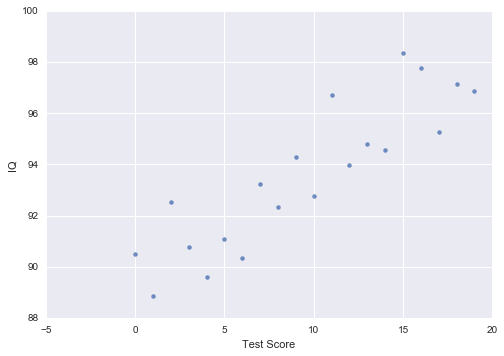

In [4]:
ax = sns.regplot(x=np.array(X), y=np.array(Y), fit_reg=False)
ax.set(xlabel='Test Score', ylabel='IQ')


In [5]:
class Session:
    def compute(self, node, feed_dict={}):
        return node.compute(feed_dict)
    
    def find_all_paths_to_variables(self, node, feed_dict={}):
        paths = node.path_to_variables([], feed_dict)
        return paths
        
    def minimize(self, node, learning_rate=0.001, feed_dict={}):
        val = self.compute(node, feed_dict)
        gradient_paths = self.find_all_paths_to_variables(node, feed_dict)
        gradient_map = self.compute_gradients(gradient_paths)
        for k, v in gradient_map.items():
            update = learning_rate * v['gradient']
            v['instance'].val -= update
            
    def compute_gradients(self, gradient_paths):
        gradient_map = {}
        for path in gradient_paths:
            # The first node will either be a variable node or a placeholder node
            klass, instance, grad = path[0]
            if klass == VariableNode:
                gradient_map[instance.name()] = {
                    'instance': instance,
                    'gradient': self.compute_gradient_for_path(path),
                }
        return gradient_map
                
    def compute_gradient_for_path(self, path):
        return reduce(lambda a, b: a * b, [g for k, i, g in path[1:]])
    
    def print_node_values(self, node, feed_dict={}):
        node.print_value(feed_dict)

In [6]:
sess = Session()
EPOCHS = 500
for i in range(EPOCHS):
    for i in range(len(X)):
        x_i = X[i]
        y_i = Y[i]
        
        sess.minimize(error, feed_dict={x: x_i, y: y_i})

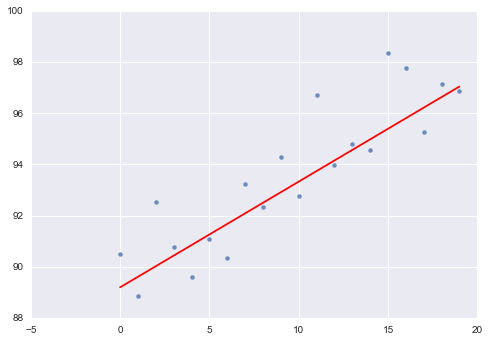

In [7]:
sns.regplot(x=np.array(X), y=np.array(Y), fit_reg=False)
points_x = np.linspace(min(X), max(X), 100)
points_y = [sess.compute(prediction, feed_dict={x:p}) for p in points_x]
plt.plot(points_x, points_y, 'r')

In [8]:
# Quadratic Model

X, Y = generate_quadratic_data()

x = PlaceholderNode(name="x")
y = PlaceholderNode(name="y")

m = VariableNode(random.random(), name="m")
b = VariableNode(random.random(), name="b")

prediction = AddNode(SquaredNode(MultiplyNode(m, x, name='multiply'), name='squared'), b, name='prediction')
cost = SubtractNode(prediction, y, name='cost')
error = SquaredNode(cost, name='error')

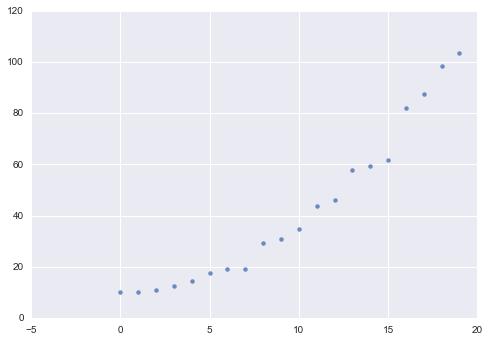

In [9]:
ax = sns.regplot(x=np.array(X), y=np.array(Y), fit_reg=False)

In [12]:
sess = Session()
EPOCHS = 50000
for i in range(EPOCHS):
    for i in range(len(X)):
        x_i = X[i]
        y_i = Y[i]
        sess.minimize(error, learning_rate=0.000001, feed_dict={x: x_i, y: y_i})
        m_val = sess.compute(m, feed_dict={x: x_i, y: y_i})
        b_val = sess.compute(b, feed_dict={x: x_i, y: y_i})
        #print("m: {}, b: {}".format(m_val, b_val))

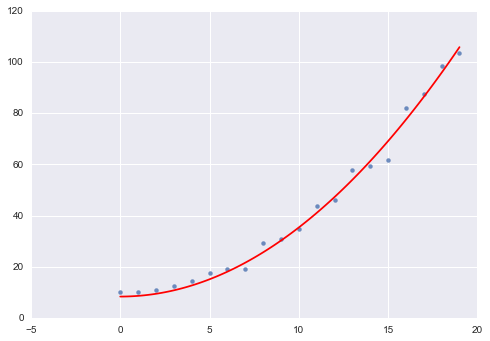

In [13]:
sns.regplot(x=np.array(X), y=np.array(Y), fit_reg=False)
points_x = np.linspace(min(X), max(X), 100)
points_y = [sess.compute(prediction, feed_dict={x:p}) for p in points_x]
plt.plot(points_x, points_y, 'r')